### IMPORTACIONES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re #regex para validar si existe subfijos
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from numpy import trapz
from scipy.ndimage import gaussian_filter1d

### LECTURA DE ARCHIVOS

In [2]:


# Lee el archivo CSV
df = pd.read_csv('converted.csv', delimiter=',')

# Muestra las primeras filas del DataFrame para verificar
print(df.head())


   Ramanshift        M1      M1.1      M1.2      M1.3        M2      M2.1  \
0    4000.123  0.028301  0.036857  0.027086  0.038974  0.046379  0.041804   
1    3999.641  0.028238  0.036855  0.027155  0.039043  0.046374  0.041753   
2    3999.159  0.028187  0.036844  0.027217  0.039126  0.046374  0.041705   
3    3998.677  0.028154  0.036833  0.027268  0.039211  0.046381  0.041669   
4    3998.195  0.028145  0.036830  0.027300  0.039283  0.046392  0.041655   

       M2.2      M2.3        M3  ...      M7.2      M7.3        M8      M8.1  \
0  0.049717  0.020970  0.039983  ...  0.058690  0.033391  0.032274  0.014542   
1  0.049791  0.020951  0.039960  ...  0.058678  0.033367  0.032182  0.014454   
2  0.049863  0.020930  0.039936  ...  0.058675  0.033339  0.032115  0.014368   
3  0.049923  0.020914  0.039916  ...  0.058681  0.033305  0.032085  0.014298   
4  0.049965  0.020909  0.039899  ...  0.058694  0.033271  0.032096  0.014255   

       M8.2      M8.3        M9      M9.1      M9.2     

 ### Verificamos si se tiene los subfijos al leer el archivo

In [3]:
if any(re.search(r'\.\d+$', col) for col in df.columns):
    # Si hay columnas con sufijos, eliminarlos
    df.columns = [re.sub(r'\.\d+$', '', col) for col in df.columns]
    print("Se eliminaron los sufijos numéricos de los encabezados.")
# Muestra las primeras filas del DataFrame para verificar
print(df.head())

Se eliminaron los sufijos numéricos de los encabezados.
   Ramanshift        M1        M1        M1        M1        M2        M2  \
0    4000.123  0.028301  0.036857  0.027086  0.038974  0.046379  0.041804   
1    3999.641  0.028238  0.036855  0.027155  0.039043  0.046374  0.041753   
2    3999.159  0.028187  0.036844  0.027217  0.039126  0.046374  0.041705   
3    3998.677  0.028154  0.036833  0.027268  0.039211  0.046381  0.041669   
4    3998.195  0.028145  0.036830  0.027300  0.039283  0.046392  0.041655   

         M2        M2        M3  ...        M7        M7        M8        M8  \
0  0.049717  0.020970  0.039983  ...  0.058690  0.033391  0.032274  0.014542   
1  0.049791  0.020951  0.039960  ...  0.058678  0.033367  0.032182  0.014454   
2  0.049863  0.020930  0.039936  ...  0.058675  0.033339  0.032115  0.014368   
3  0.049923  0.020914  0.039916  ...  0.058681  0.033305  0.032085  0.014298   
4  0.049965  0.020909  0.039899  ...  0.058694  0.033271  0.032096  0.014255   



In [4]:
unique_headers = df.columns.unique()
print("\nEncabezados únicos:")
print(unique_headers)

# Identificar los tipos únicos de valores en los encabezados
unique_types = set(col for col in df.columns if col != "Ramanshift")


Encabezados únicos:
Index(['Ramanshift', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'], dtype='object')


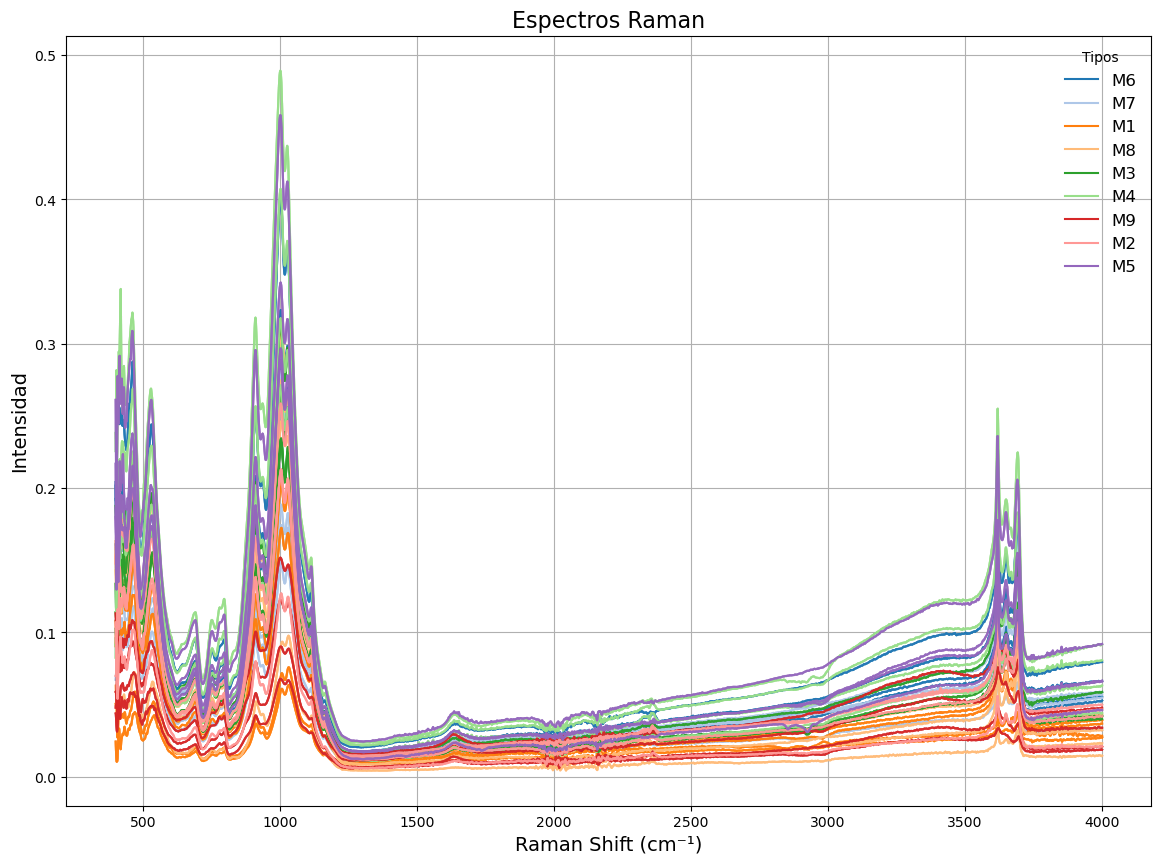

In [5]:
# Colores para cada tipo
colors = plt.cm.tab20.colors  # Una paleta de colores suficientemente grande
color_map = {unique: colors[i % len(colors)] for i, unique in enumerate(unique_types)}

# Graficar cada tipo una sola vez en la leyenda
plt.figure(figsize=(14, 10))

for unique_type in unique_types:
    # Filtrar las columnas correspondientes al tipo actual
    columns = [col for col in df.columns if col.startswith(unique_type)]
    
    # Graficar todas las columnas del tipo actual
    for col in columns:
        plt.plot(df['Ramanshift'], df[col], color=color_map[unique_type], alpha=0.6)
    
    # Agregar una entrada en la leyenda solo para el tipo (una vez)
    plt.plot([], [], label=unique_type, color=color_map[unique_type])  # Dummy plot for legend

# Etiquetas y leyendas
plt.title("Espectros Raman", fontsize=16)
plt.xlabel("Raman Shift (cm⁻¹)", fontsize=14)
plt.ylabel("Intensidad", fontsize=14)
plt.legend(title="Tipos", fontsize=12, loc='upper right', frameon=False)
plt.grid(True)

# Mostrar la gráfica
plt.show()

### En este caso pediremos al usuario ingresar algun tipo para graficar, para tener una idea de como se ve los espectros para cada uno de los tipos existentes en el archivo.

<div class="alert alert-block alert-info">
<b>PD:</b> Aqui solo se mostraran hasta 10 como cantidad maxima de columnas para tipo, es para una referencia y no tener una carga de datos excesiva 
</div>

In [6]:
# Configurar el tipo de espectro que se desea graficar
tipo_espectro = input(f"Ingrese el tipo de espectro para graficar (opciones: {', '.join(unique_types)}): ").strip()

# Filtrar las columnas correspondientes al tipo de espectro ingresado
columnas_tipo = [col for col in df.columns if col.startswith(tipo_espectro)]

if columnas_tipo:
    # Limitar el número de columnas graficadas
    max_columns = 10
    columnas_tipo = columnas_tipo[:max_columns]

    # Reducir la cantidad de datos graficados
    sampled_df = df.iloc[::10, :]

    # Crear la gráfica
    plt.figure(figsize=(14, 8))

    # Graficar todas las líneas sin leyenda
    for col in columnas_tipo:
        plt.plot(sampled_df['Ramanshift'], sampled_df[col], alpha=0.7)

    # Añadir una entrada única en la leyenda para el tipo
    plt.plot([], [], label=tipo_espectro, color='black') 

    # Etiquetas y leyenda
    plt.title(f"Espectro Raman - {tipo_espectro} (muestra de columnas y filas)", fontsize=16)
    plt.xlabel("Raman Shift (cm⁻¹)", fontsize=14)
    plt.ylabel("Intensidad", fontsize=14)
    plt.legend(title="Espectros", fontsize=10, loc='upper right', frameon=False)
    plt.grid(True)

    # Mostrar la gráfica
    plt.show()
else:
    print(f"No se encontraron columnas para el tipo de espectro '{tipo_espectro}'. Verifique el nombre e intente nuevamente.")


Ingrese el tipo de espectro para graficar (opciones: M6, M7, M1, M8, M3, M4, M9, M2, M5): glycogen
No se encontraron columnas para el tipo de espectro 'glycogen'. Verifique el nombre e intente nuevamente.


# <center>Analisis PCA</center>
### ¿Por qué utilizar PCA en espectros?
En datos espectroscópicos (como los Raman), los conjuntos de datos suelen tener alta dimensionalidad y las variables (picos) pueden estar correlacionadas. El PCA es útil porque:

**Reduce la dimensionalidad:** Permite analizar un número menor de variables representativas. <br>
**Captura patrones esenciales:** Identifica las características espectrales clave. <br>
**Mejora la visualización:** Ayuda a visualizar datos complejos en gráficos 2D o 3D.  <br>
**Preprocesamiento:** Facilita la clasificación o el análisis posterior (por ejemplo, identificación de muestras).

<img src=pca-analysis.gif>


### Cálculo del PCA
**Calcular la matriz de covarianza:** Representa cómo varían las variables juntas.<br>
**Obtener los valores y vectores propios:** Los valores propios determinan la importancia (varianza explicada) de cada componente, y los vectores propios indican la dirección de los nuevos ejes. <br>
**Proyección de los datos:** Transformar los datos originales en los nuevos ejes definidos por los componentes principales.

### Aplicación práctica en espectros
#### En espectros Raman:

**Objetivo:** Identificar patrones comunes entre muestras (como grupos químicos) o distinguir diferencias entre ellas. <br>
**Componentes principales:** Representan características espectrales clave que explican la mayoría de las variaciones entre los espectros. 

<div class="alert alert-block alert-danger">
<b>Limitaciones PCA:</b> Es una técnica lineal, lo que significa que no captura relaciones no lineales en los datos.
Los componentes principales pueden ser difíciles de interpretar físicamente.
Depende de la correcta estandarización y limpieza de los datos.
</div>



# <center>Fundamento matemático</center>

### 1. Matriz de datos
Dado un conjunto de datos con 
𝑚
m muestras y 
𝑛
n variables, representamos los datos en una matriz de datos 
𝑋
X de tamaño 
𝑚
×
𝑛
m×n:
$$
X = 
\begin{bmatrix}
x_{11} & x_{12} & \dots & x_{1n} \\
x_{21} & x_{22} & \dots & x_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
x_{m1} & x_{m2} & \dots & x_{mn}
\end{bmatrix}
$$

Donde cada fila es una muestra, y cada columna es una variable (por ejemplo, la intensidad de un espectro en una longitud de onda específica).

### 2. Estandarización
El PCA requiere que las variables tengan media 0 y desviación estándar 1. Para ello, estandarizamos cada variable:

$$
z_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j}
$$

#### 1. Fórmula para estandarización de los datos

$$
z_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j}
$$

Donde:

- \( \mu_j \): Media de la variable \( j \).
- \( \sigma_j \): Desviación estándar de la variable \( j \).

Esto nos da una nueva matriz \( Z \), estandarizada.

---



In [7]:
# Volver a realizar la estandarización con las columnas corregidas
data_no_suffix = df.drop(columns=["Ramanshift"])  # Eliminar la columna 'Ramanshift'

# Estandarizar los datos nuevamente
scaler = StandardScaler()
data_standardized_no_suffix = scaler.fit_transform(data_no_suffix)


# Convertir la matriz estandarizada en un DataFrame para inspección
data_standardized_no_suffix_df = pd.DataFrame(data_standardized_no_suffix, columns=data_no_suffix.columns)

# Mostrar las primeras filas del DataFrame estandarizado sin sufijos
data_standardized_no_suffix_df.head()


,M1,M1,M1,M1,M2,M2,M2,M2,M3,M3,...,M7,M7,M8,M8,M8,M8,M9,M9,M9,M9
0,0.444668,0.017098,0.765849,-0.056423,-0.121669,-0.056519,0.042947,-0.169567,-0.217998,-0.061505,...,-0.015573,-0.022184,-0.189298,-0.120798,-0.276367,-0.131935,-0.083188,-0.181834,-0.031808,0.042910
1,0.438834,0.017028,0.773529,-0.054337,-0.121785,-0.057961,0.045126,-0.170433,-0.218519,-0.063588,...,-0.015839,-0.023174,-0.191297,-0.126246,-0.275540,-0.132955,-0.082483,-0.189395,-0.027342,0.043064
2,0.434015,0.016640,0.780430,-0.051826,-0.121785,-0.059318,0.047246,-0.171389,-0.219063,-0.065434,...,-0.015905,-0.024330,-0.192752,-0.131570,-0.275091,-0.134053,-0.081496,-0.196393,-0.022132,0.041986
3,0.430941,0.016252,0.786106,-0.049256,-0.121622,-0.060336,0.049013,-0.172117,-0.219516,-0.067069,...,-0.015772,-0.025732,-0.193404,-0.135903,-0.275020,-0.135092,-0.080555,-0.201892,-0.017005,0.039907
4,0.430112,0.016146,0.789667,-0.047079,-0.121367,-0.060732,0.050249,-0.172345,-0.219901,-0.068520,...,-0.015485,-0.027135,-0.193165,-0.138565,-0.275374,-0.135798,-0.080085,-0.205079,-0.012870,0.037174


### 3. Matriz de covarianza

La matriz de covarianza mide cómo varían las variables entre sí:

$$
C = \frac{1}{m - 1} Z^\top Z
$$

Donde:

- \( C \): Es la matriz de covarianza (\( n \times n \)).
- \( Z^\top \): La transpuesta de la matriz estandarizada \( Z \).

Cada elemento de \( C \), \( c_{ij} \), mide la covarianza entre las variables \( i \) y \( j \):

$$
c_{ij} = \frac{1}{m-1} \sum_{k=1}^m (z_{ki} - \bar{z}_i)(z_{kj} - \bar{z}_j)
$$

---



In [8]:
# Calcular la matriz de covarianza a partir de los datos estandarizados
covariance_matrix = np.cov(data_standardized_no_suffix.T)

# Convertir la matriz de covarianza a un DataFrame para visualización
covariance_matrix_df = pd.DataFrame(
    covariance_matrix,
    index=data_no_suffix.columns,
    columns=data_no_suffix.columns
)

# Mostrar las primeras filas de la matriz de covarianza
covariance_matrix_df.head()


,M1,M1,M1,M1,M2,M2,M2,M2,M3,M3,...,M7,M7,M8,M8,M8,M8,M9,M9,M9,M9
M1,1.000134,0.924171,0.982014,0.911595,0.895957,0.911763,0.928172,0.891603,0.888600,0.913428,...,0.914087,0.920498,0.868993,0.892898,0.846227,0.877199,0.924817,0.909516,0.919306,0.924549
M1,0.924171,1.000134,0.899771,0.998361,0.994709,0.998417,0.994977,0.992933,0.994309,0.997344,...,0.995051,0.998052,0.986041,0.982248,0.979143,0.988788,0.961051,0.978544,0.979209,0.939995
M1,0.982014,0.899771,1.000134,0.888051,0.864277,0.888395,0.914727,0.855201,0.862042,0.890190,...,0.894205,0.896691,0.837242,0.859329,0.815101,0.848258,0.919940,0.898060,0.894023,0.924032
M1,0.911595,0.998361,0.888051,1.000134,0.995315,0.998436,0.993185,0.994953,0.996443,0.998318,...,0.994011,0.997942,0.991984,0.986053,0.985779,0.994312,0.954149,0.975755,0.974657,0.929125
M2,0.895957,0.994709,0.864277,0.995315,1.000134,0.996971,0.989493,0.995358,0.996387,0.993975,...,0.994819,0.995695,0.987587,0.976285,0.981636,0.990493,0.954279,0.976151,0.978359,0.931011


<div class="alert alert-block alert-info">
<b>Matriz De Covarianza Raman</b> Se ha calculado la matriz de covarianza a partir de los datos estandarizados. Esta matriz representa cómo varían las variables (columnas del espectro) entre sí.
</div>



### 4. Descomposición en valores propios

El PCA se basa en encontrar los vectores propios (\( v \)) y los valores propios (\( \lambda \)) de la matriz de covarianza:

$$
C v = \lambda v
$$

Donde:

- \( v \): Es el vector propio (dirección del nuevo eje).
- \( \lambda \): Es el valor propio (cuánta varianza explica ese eje).

Los valores propios están ordenados de mayor a menor y representan la cantidad de varianza explicada por cada componente principal.

---

In [9]:
# Descomposición en valores propios y vectores propios
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Convertir los valores propios en un DataFrame para inspección
eigenvalues_df = pd.DataFrame(eigenvalues, columns=["Valor Propio"])

# Convertir los vectores propios en un DataFrame para inspección
eigenvectors_df = pd.DataFrame(
    eigenvectors,
    index=data_no_suffix.columns,
    columns=[f"PC{i+1}" for i in range(eigenvectors.shape[1])]
)

# Mostrar los valores propios y vectores propios
eigenvalues_df.head()
eigenvectors_df.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
M1,-0.156108,0.424375,0.424467,0.078767,-0.421104,-0.092960,-0.186350,0.316507,0.429672,-0.194603,...,-0.002278,-0.028403,0.019954,0.068630,-0.024982,-0.022615,-0.030290,-0.013312,0.011325,0.001523
M1,-0.168550,-0.030596,0.096552,-0.016112,-0.029247,-0.036139,-0.186867,-0.069821,-0.222672,-0.108191,...,-0.078350,-0.125034,0.047922,0.181423,0.064659,-0.061240,0.051990,0.161797,-0.054618,0.155925
M1,-0.152572,0.518718,0.368461,0.146871,0.406502,0.015115,0.142494,-0.209058,-0.067728,0.312748,...,-0.053311,0.001352,-0.059348,-0.044732,0.023113,0.015118,0.004134,-0.071001,-0.003644,-0.036027
M1,-0.168341,-0.077784,0.108738,-0.012928,0.087455,0.000375,-0.010222,0.012096,-0.152026,-0.022566,...,0.329181,0.105951,0.354134,0.146620,0.076565,0.143311,-0.135899,0.157662,0.050880,0.113382
M2,-0.168096,-0.106738,-0.021460,-0.025676,-0.235668,0.108263,0.042326,-0.003712,0.008906,0.326489,...,0.206707,-0.217604,-0.169047,-0.070863,-0.001230,-0.138865,0.072366,-0.111553,0.275025,0.037714


*La descomposición en valores propios y vectores propios de la matriz de covarianza se ha realizado correctamente:*<br>
**Valores propios (eigenvalues):** Indican la cantidad de varianza explicada por cada componente principal.<br>
**Vectores propios (eigenvectors):** Representan las direcciones (ejes) de los nuevos componentes principales en el espacio original.

### 5 Transformación de los datos

Los datos originales se transforman proyectándolos en los ejes definidos por los vectores propios:

$$
T = Z V
$$

Donde:

- \( T \): Matriz transformada (nuevos datos en el espacio de los componentes principales).
- \( V \): Matriz cuyas columnas son los vectores propios (direcciones principales).

Cada fila de \( T \) es la representación de una muestra en el espacio reducido.

---

In [10]:
# Proyección de los datos originales en los ejes definidos por los componentes principales
transformed_data = np.dot(data_standardized_no_suffix, eigenvectors)

# Convertir los datos transformados en un DataFrame para inspección
transformed_data_df = pd.DataFrame(
    transformed_data,
    columns=[f"PC{i+1}" for i in range(transformed_data.shape[1])]
)

# Mostrar los primeros datos transformados
transformed_data_df.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
0,0.071607,0.964492,0.383712,0.371086,-0.007835,0.014474,0.152046,-0.190735,-0.093998,0.060603,...,0.008311,-0.009736,-0.011541,0.002440,-0.008619,-0.001499,-0.000264,0.007605,-0.000713,0.007031
1,0.074523,0.967782,0.382590,0.373873,-0.005033,0.014680,0.156047,-0.196636,-0.097748,0.062040,...,0.009023,-0.009130,-0.009240,0.000766,-0.007739,-0.001574,0.002426,0.008225,-0.000415,0.006907
2,0.077426,0.970844,0.381969,0.376101,-0.002953,0.015403,0.160224,-0.202122,-0.100666,0.062751,...,0.010044,-0.008781,-0.006947,-0.000863,-0.006233,-0.001351,0.004993,0.008532,0.000087,0.006569
3,0.079875,0.973465,0.382318,0.377531,-0.001787,0.016429,0.163970,-0.206504,-0.102472,0.063027,...,0.011185,-0.008685,-0.004970,-0.002181,-0.004230,-0.000890,0.007138,0.008534,0.000646,0.006218
4,0.081631,0.975187,0.383761,0.377986,-0.001822,0.017586,0.166715,-0.209100,-0.102989,0.063081,...,0.012196,-0.008826,-0.003643,-0.002948,-0.002027,-0.000157,0.008469,0.008287,0.001067,0.005918


*Resultados:* <br>
**Cada fila:** Representa una muestra en el espacio PCA. <br>
**Cada columna (PC1, PC2, ...):** Representa un componente principal.

### 6. Varianza explicada

La proporción de varianza explicada por cada componente principal es:

$$
\text{Varianza explicada} = \frac{\lambda_i}{\sum \lambda}
$$

Esto nos dice cuánto contribuye cada componente principal a la variabilidad total de los datos.

In [11]:
# Calcular la varianza explicada por cada componente principal
explained_variance = eigenvalues / np.sum(eigenvalues)

# Calcular la varianza acumulada
cumulative_variance = np.cumsum(explained_variance)

pc1 = transformed_data[:, 0]
pc2 = transformed_data[:, 1]

# Crear un gráfico de dispersión utilizando PC1 y PC2
#plt.figure(figsize=(10, 6))
#plt.scatter(pc1, pc2, alpha=0.7, edgecolor='k')
#plt.xlabel("Componente Principal 1 (PC1)", fontsize=14)
#plt.ylabel("Componente Principal 2 (PC2)", fontsize=14)
#plt.title("Proyección de Espectros en el Espacio PCA", fontsize=16)
#plt.grid(True)

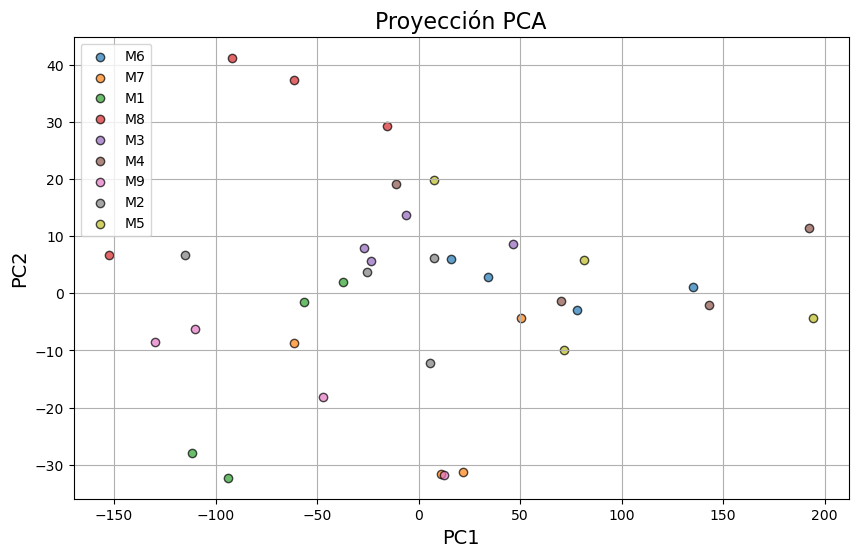

In [12]:

# Leer el archivo CSV y excluir la primera columna (ejemplo: Ramanshift)
data = df.iloc[:, 1:]

# Obtener las categorías desde los nombres de las columnas
# Se asume que los nombres de las columnas contienen las categorías como parte del texto
categories = [col.split('_')[0] for col in data.columns]  # Divide por un delimitador como "_" (ajusta según tu formato)
unique_categories = list(set(categories))  # Categorías únicas

# Asignar un color único a cada categoría
colors = plt.cm.tab10.colors  # Paleta de colores
category_colors = {category: colors[i % len(colors)] for i, category in enumerate(unique_categories)}

# Escalar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.T)  # Transposición para que las características sean columnas

# Aplicar PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# Graficar el PCA con colores por tipo
plt.figure(figsize=(10, 6))
for category in unique_categories:
    indices = [i for i, cat in enumerate(categories) if cat == category]
    plt.scatter(
        pca_result[indices, 0],
        pca_result[indices, 1],
        label=category,
        color=category_colors[category],
        alpha=0.7,
        edgecolor='k'
    )

# Etiquetas y leyenda
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)
plt.title('Proyección PCA', fontsize=16)
plt.legend(loc='best', fontsize=10)
plt.grid(True)
plt.show()


## <center>¿Por qué suavizar los datos antes del PCA?</center>

### Reducción de ruido: 

En espectros, el ruido puede distorsionar las señales reales y hacer que el PCA se enfoque en variaciones no representativas.
Suavizar elimina fluctuaciones pequeñas e irrelevantes, dejando solo las tendencias principales.<br>

### Mejor representación de los patrones:

Las características significativas (picos y valles) de un espectro se destacan mejor después del suavizado.
El PCA trabajará sobre señales más limpias y representativas, en lugar de desviaciones causadas por el ruido.

### Reducir complejidad: 

Suavizar puede disminuir la cantidad de detalles excesivos en los datos, facilitando la identificación de las principales componentes. 


### Mejor interpretación de los resultados:

Los componentes principales extraídos del PCA serán más fáciles de relacionar con características relevantes de los datos (como picos en un espectro).


## <center> ¿Cuándo no es necesario suavizar? </center> 
Si los datos ya son de alta calidad y el ruido es mínimo, el suavizado puede no ser necesario.
Un exceso de suavizado puede eliminar detalles importantes, lo que podría llevar a perder información relevante.

# <center>Métodos de suavizado comunes</center>

## **1. Savitzky-Golay Filter**
- Realiza un ajuste polinómico local en una ventana móvil.
- Ideal para espectros, ya que preserva los picos y las características de la señal.

**Fórmula:**
$$
y'(t) = \sum_{k=-m}^{m} c_k \cdot x(t+k)
$$

Donde:

- $$y'(t)$$: Señal suavizada.
- $$c_k$$: Coeficientes del polinomio.
- $$x(t+k)$$: Valores originales en la ventana móvil.

---


<img src=filtro-sg.ppm>

In [13]:
# Parámetros para suavizar
window_length = 11  # Longitud de la ventana (debe ser impar)
polyorder = 3       # Orden del polinomio

### 1. <font color="blue">window_length:</font> Longitud de la ventana
**Definición:** Es el número de puntos consecutivos que se utilizan para ajustar un polinomio en el proceso de suavizado.
#### Requisitos:
Debe ser un número entero impar (por ejemplo, 5, 7, 9, 11, etc.).
Debe ser mayor que el orden del polinomio (polyorder).
### Impacto:
**Ventana pequeña:** El suavizado será más localizado y detallado, pero puede no eliminar bien el ruido.<br>
**Ventana grande:** El suavizado será más amplio y eliminará más ruido, pero podría borrar picos o detalles importantes.

### 2. <font color="blue">polyorder:</font> Orden del polinomio
**Definición:** Es el grado del polinomio que se ajusta a los puntos dentro de cada ventana.
### Requisitos:
Debe ser un número entero no negativo.
Debe ser menor que el tamaño de la ventana (window_length).
### Impacto:
**Orden bajo (e.g., 2 o 3):** Se ajusta a tendencias generales y no captura oscilaciones rápidas.<br>
**Orden alto (e.g., 4 o más):** Captura más detalles locales, pero puede amplificar el ruido si se usa con datos ruidosos.

In [14]:
# Aplicar Savitzky-Golay al dataset
data_smoothed = savgol_filter(df.iloc[:, 1:], window_length=window_length, polyorder=polyorder, axis=0)

### Cómo funciona <font color="blue">savgol_filter</font>
El filtro realiza un ajuste polinómico en ventanas móviles de datos. Dentro de cada ventana, se ajusta un polinomio de un grado específico a los datos y luego se usa ese polinomio para calcular el valor suavizado del punto central.

**Ventana móvil:**<br>
Es un subconjunto de datos de longitud definida por el parámetro window_length.<br>
La ventana se mueve a través de la señal, centrada en cada punto que se va a suavizar.<br>
**Ajuste polinómico:**<br>
Dentro de cada ventana, se ajusta un polinomio de grado polyorder.<br>
El valor del punto central de la ventana se reemplaza por el valor del polinomio ajustado.<br>
**Repetición:**<br>
El proceso se repite para cada punto de la señal, excepto en los extremos, donde la ventana no puede ser completamente centrada. En esos casos, se utiliza un método de extrapolación.

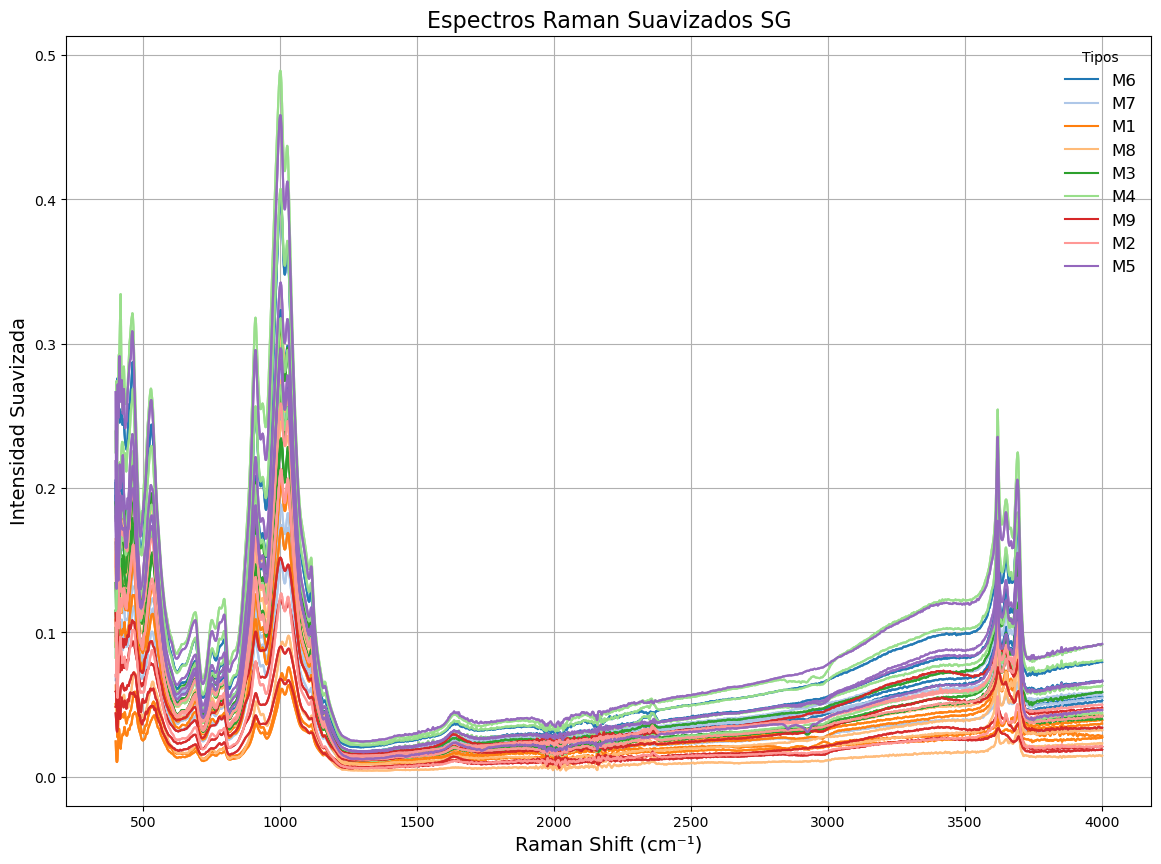

In [15]:
# Crear un DataFrame con los datos suavizados
df_smoothed = pd.DataFrame(data_smoothed, columns=df.columns[1:])
df_smoothed.insert(0, 'Ramanshift', df['Ramanshift'])  # Insertar de vuelta la columna 'Ramanshift' que quitamos para
#poder suavizar

# Obtener los tipos únicos desde los nombres de las columnas
unique_types = set(col.split('_')[0] for col in df.columns[1:])  # Ajusta el separador si es necesario

# Crear un mapa de colores
colors = plt.cm.tab20.colors  # con 20 colores si podra colorear
color_map = {unique: colors[i % len(colors)] for i, unique in enumerate(unique_types)}

# Graficar los espectros suavizados
plt.figure(figsize=(14, 10))

for unique_type in unique_types:
    # Filtrar las columnas correspondientes al tipo actual
    columns = [col for col in df.columns if col.startswith(unique_type)]
    
    # Graficar todas las columnas del tipo actual
    for col in columns:
        plt.plot(df_smoothed['Ramanshift'], df_smoothed[col], color=color_map[unique_type], alpha=0.6)
    
    # Agregar una entrada en la leyenda solo para el tipo (una vez)
    plt.plot([], [], label=unique_type, color=color_map[unique_type])  # Dummy plot for legend

# Etiquetas y leyendas
plt.title("Espectros Raman Suavizados SG", fontsize=16)
plt.xlabel("Raman Shift (cm⁻¹)", fontsize=14)
plt.ylabel("Intensidad Suavizada", fontsize=14)
plt.legend(title="Tipos", fontsize=12, loc='upper right', frameon=False)
plt.grid(True)

# Mostrar la gráfica
plt.show()


## 2. Filtro Gaussiano
El filtro gaussiano es una técnica de suavizado que se utiliza para reducir el ruido en los espectros (como los espectros Raman) preservando las características principales, como los picos. Este filtro aplica una convolución entre los datos espectrales y una función gaussiana, lo que atenúa las variaciones rápidas (ruido) y retiene los patrones de baja frecuencia (picos y formas importantes).

### Cómo funciona el filtro gaussiano
**Definición de la función gaussiana:** La función gaussiana es una curva en forma de campana que da más peso a los puntos cercanos al valor central. Matemáticamente, se define como:

$$
G(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{x^2}{2\sigma^2}}
$$

Donde: <br>
G(x): Valor de la función gaussiana en un punto <br>
σ: Desviación estándar, que determina el ancho de la curva gaussiana.

**Aplicación en el espectro:**

* Se toma una ventana alrededor de cada punto del espectro.
* Se calcula un promedio ponderado de los valores dentro de la ventana, donde los pesos están determinados por la función gaussiana. <br>

**Atenuación del ruido:**

El ruido, que tiende a tener variaciones rápidas, se atenúa debido al promedio ponderado.
Las características principales, como los picos del espectro, se preservan.


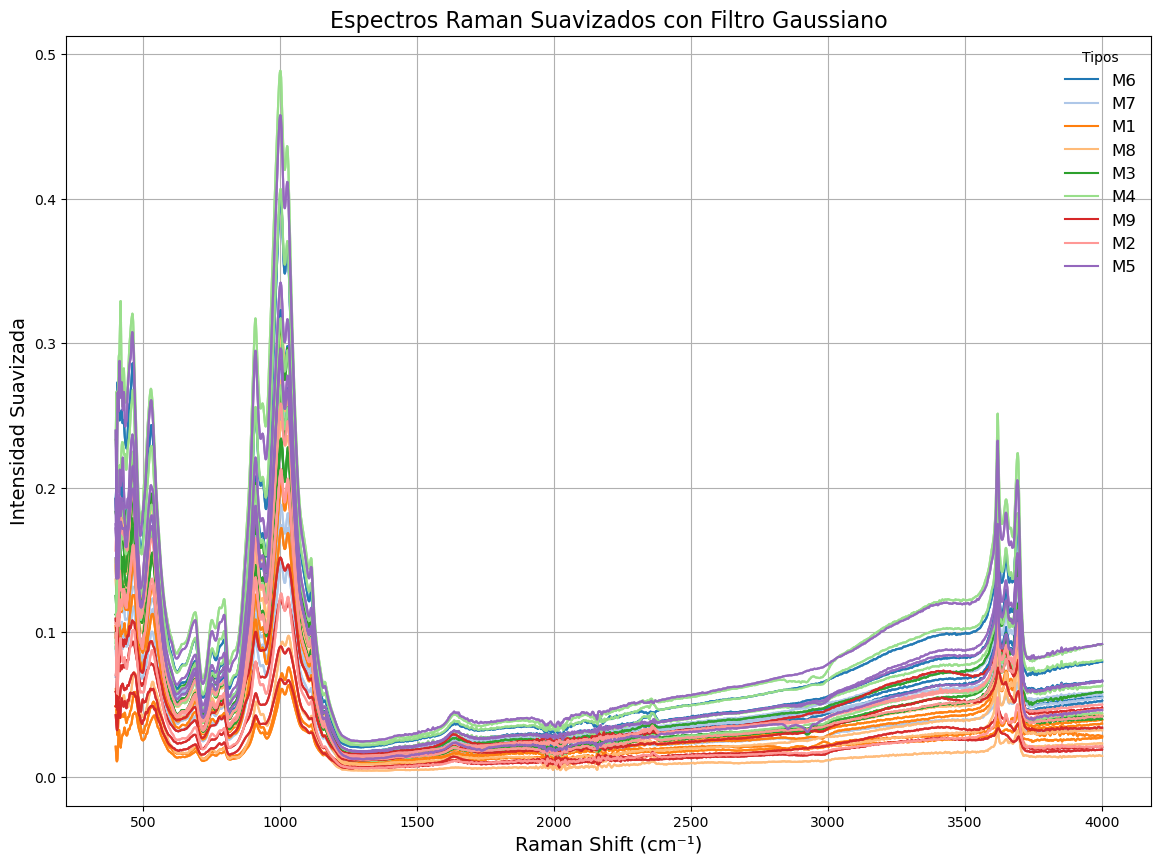

In [16]:


# Parámetros para el filtro gaussiano
sigma = 2  # Desviación estándar del filtro

# Aplicar el filtro gaussiano a los datos espectrales
data_smoothed_gaussian = gaussian_filter1d(df.iloc[:, 1:].values, sigma=sigma, axis=0)

# Crear un DataFrame con los datos suavizados
df_smoothed_gaussian = pd.DataFrame(data_smoothed_gaussian, columns=df.columns[1:])
df_smoothed_gaussian.insert(0, 'Ramanshift', df['Ramanshift'])  # Insertar la columna 'Ramanshift'

# Obtener los tipos únicos desde los nombres de las columnas
unique_types = set(col.split('_')[0] for col in df.columns[1:])  # Ajusta el separador si es necesario

# Crear un mapa de colores
colors = plt.cm.tab20.colors  # Paleta de colores suficientemente grande
color_map = {unique: colors[i % len(colors)] for i, unique in enumerate(unique_types)}

# Graficar los espectros suavizados
plt.figure(figsize=(14, 10))

for unique_type in unique_types:
    # Filtrar las columnas correspondientes al tipo actual
    columns = [col for col in df.columns if col.startswith(unique_type)]
    
    # Graficar todas las columnas del tipo actual
    for col in columns:
        plt.plot(df_smoothed_gaussian['Ramanshift'], df_smoothed_gaussian[col], color=color_map[unique_type], alpha=0.6)
    
    # Agregar una entrada en la leyenda solo para el tipo (una vez)
    plt.plot([], [], label=unique_type, color=color_map[unique_type])  # Dummy plot for legend

# Etiquetas y leyendas
plt.title("Espectros Raman Suavizados con Filtro Gaussiano", fontsize=16)
plt.xlabel("Raman Shift (cm⁻¹)", fontsize=14)
plt.ylabel("Intensidad Suavizada", fontsize=14)
plt.legend(title="Tipos", fontsize=12, loc='upper right', frameon=False)
plt.grid(True)

# Mostrar la gráfica
plt.show()


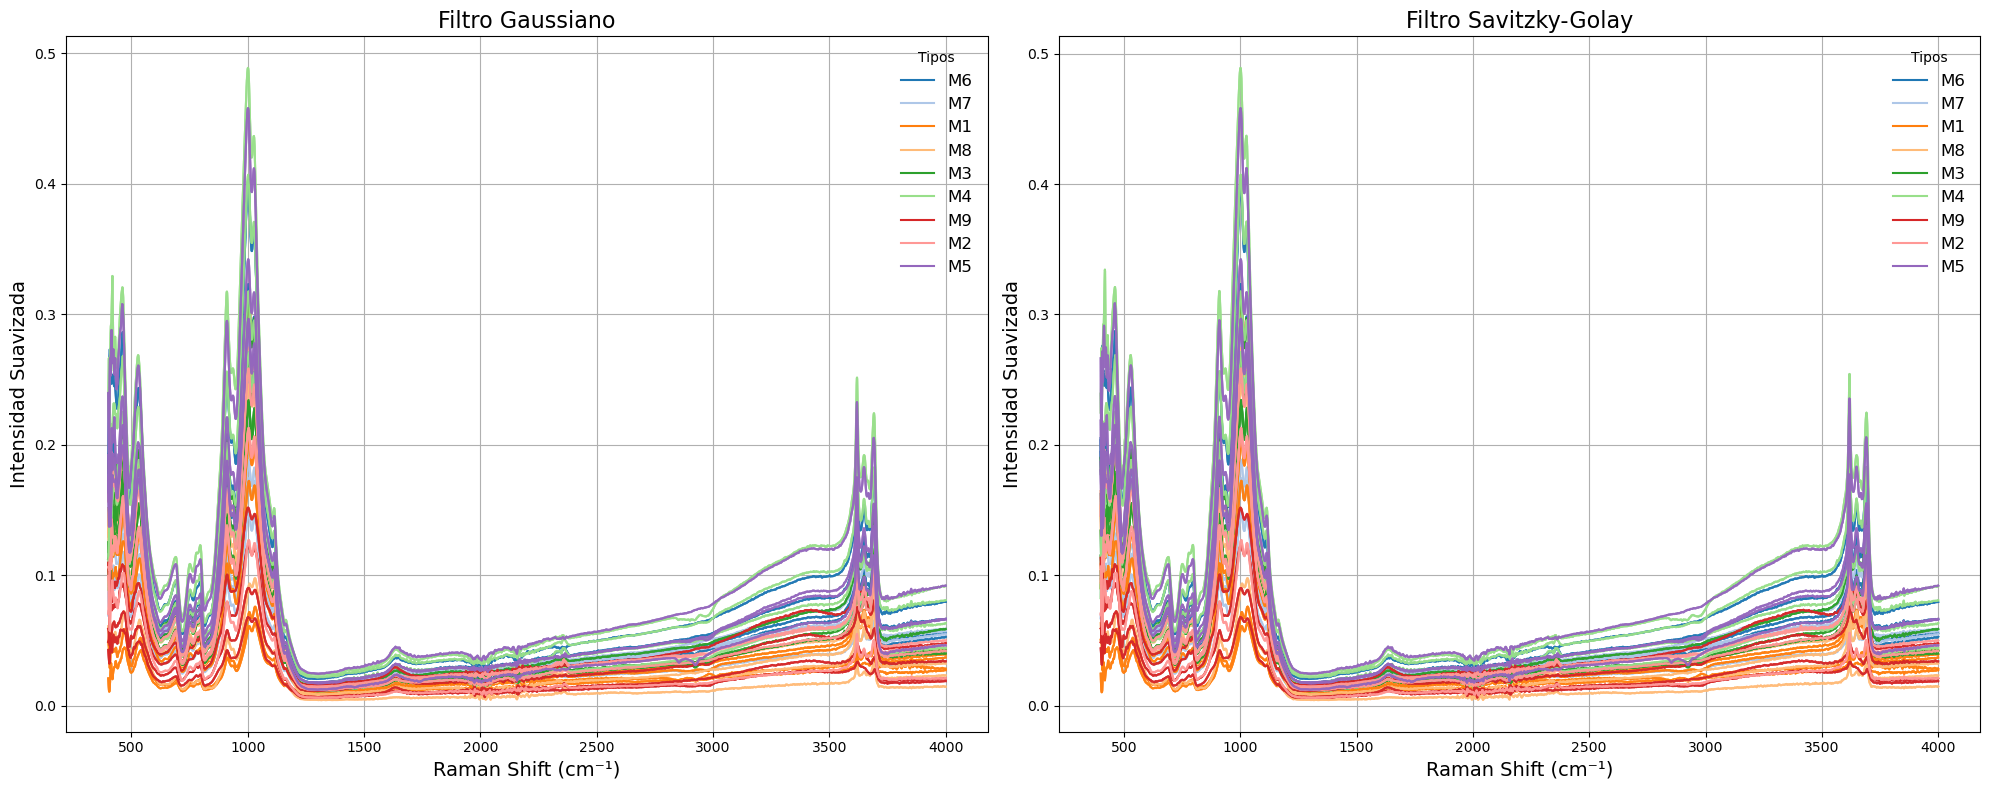

In [17]:
# Graficar los espectros suavizados para comparar con colores diferentes por tipo
plt.figure(figsize=(20, 8))

# Crear un mapa de colores
unique_types = set(col.split('_')[0] for col in df_smoothed_gaussian.columns[1:])
colors = plt.cm.tab20.colors
color_map = {unique: colors[i % len(colors)] for i, unique in enumerate(unique_types)}

# Subplot para el filtro gaussiano
plt.subplot(1, 2, 1)
for unique_type in unique_types:
    columns = [col for col in df_smoothed_gaussian.columns if col.startswith(unique_type)]
    for col in columns:
        plt.plot(df_smoothed_gaussian['Ramanshift'], df_smoothed_gaussian[col], color=color_map[unique_type], alpha=0.6)
    plt.plot([], [], label=unique_type, color=color_map[unique_type])  # Dummy plot for legend
plt.title("Filtro Gaussiano", fontsize=16)
plt.xlabel("Raman Shift (cm⁻¹)", fontsize=14)
plt.ylabel("Intensidad Suavizada", fontsize=14)
plt.legend(title="Tipos", fontsize=12, loc='upper right', frameon=False)
plt.grid(True)

# Subplot para el filtro Savitzky-Golay
plt.subplot(1, 2, 2)
for unique_type in unique_types:
    columns = [col for col in df_smoothed.columns if col.startswith(unique_type)]
    for col in columns:
        plt.plot(df_smoothed['Ramanshift'], df_smoothed[col], color=color_map[unique_type], alpha=0.6)
    plt.plot([], [], label=unique_type, color=color_map[unique_type])  # Dummy plot for legend
plt.title("Filtro Savitzky-Golay", fontsize=16)
plt.xlabel("Raman Shift (cm⁻¹)", fontsize=14)
plt.ylabel("Intensidad Suavizada", fontsize=14)
plt.legend(title="Tipos", fontsize=12, loc='upper right', frameon=False)
plt.grid(True)

# Ajustar y mostrar
plt.tight_layout()
plt.show()


**Filtro de Savitzky-Golay:**
* Utiliza un ajuste polinómico en una ventana móvil.
* Si los parámetros de longitud de ventana (window_length) y orden del polinomio (polyorder) están ajustados de manera conservadora, el resultado será muy similar al de un filtro gaussiano. <br>

**Filtro Gaussiano:**<br>
* Realiza una convolución con una función gaussiana.
* El parámetro clave es 𝜎 (desviación estándar), que controla la suavidad.<bR>

<div class="alert alert-block alert-info">
Si la longitud de ventana de Savitzky-Golay y 𝜎 en el filtro gaussiano son equivalentes en términos de suavizado, las gráficas resultantes serán casi idénticas.
</div>



#### Diferencias:
Calcula la diferencia absoluta entre los datos suavizados por cada filtro:

In [18]:
difference = df_smoothed_gaussian.iloc[:, 1:] - df_smoothed.iloc[:, 1:]
print(difference.abs().sum())

M1    0.304769
M1    0.301477
M1    0.209200
M1    0.275396
M2    0.389722
M2    0.284602
M2    0.286469
M2    0.254595
M3    0.393761
M3    0.354400
M3    0.360989
M3    0.423181
M4    0.512220
M4    0.353876
M4    0.425815
M4    0.531825
M5    0.334118
M5    0.492274
M5    0.582440
M5    0.444079
M6    0.458105
M6    0.347151
M6    0.367102
M6    0.416129
M7    0.306058
M7    0.315218
M7    0.388478
M7    0.240788
M8    0.352904
M8    0.223485
M8    0.320533
M8    0.370235
M9    0.237609
M9    0.187340
M9    0.194875
M9    0.260896
dtype: float64


# <center>Normalizacion de los espectros</center>

Normalizar el espectro es un proceso que consiste en escalar o transformar los datos de un espectro a un rango o referencia común. Esto se hace para poder comparar diferentes espectros entre sí, y para eliminar variaciones aleatorias en la amplitud de cada intensidad.
### Métodos de Normalización y Sus Casos de Uso

| **Método**                 | **Propósito**                                                                 |
|----------------------------|------------------------------------------------------------------------------|
| **Escalado Min-Max**       | Cuando los datos necesitan estar en un rango específico (por ejemplo, [0, 1]).|
| **Z-Score (Estandarización)** | Cuando se necesita centrar y escalar los datos (por ejemplo, para PCA o agrupamiento). |
| **Normalización por Área** | Comparar formas o perfiles (por ejemplo, en espectroscopía o cromatografía).  |
| **Normalización por Máximo** | Resaltar intensidades relativas (por ejemplo, en datos espectrales).          |


In [19]:
# 1. Normalización por valor máximo
df_normalized_max = df.iloc[:, 1:].div(df.iloc[:, 1:].max(axis=0), axis=1)
df_normalized_max.insert(0, 'Ramanshift', df['Ramanshift'])  # Reinsertar la columna 'Ramanshift'

# 2. Normalización por área bajo la curva
areas = trapz(df.iloc[:, 1:].values, x=df['Ramanshift'].values, axis=0)
df_normalized_area = df.iloc[:, 1:].div(areas, axis=1)
df_normalized_area.insert(0, 'Ramanshift', df['Ramanshift'])

# 3. Normalización Z-Score
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.iloc[:, 1:])
df_normalized_zscore = pd.DataFrame(data_scaled, columns=df.columns[1:])
df_normalized_zscore.insert(0, 'Ramanshift', df['Ramanshift'])

# Mostrar las primeras filas de los DataFrames normalizados para inspección

df_normalized_max.head()
df_normalized_area.head()
df_normalized_zscore.head()
#print(df_normalized_zscore)

,Ramanshift,M1,M1,M1,M1,M2,M2,M2,M2,M3,...,M7,M7,M8,M8,M8,M8,M9,M9,M9,M9
0,4000.123,0.444668,0.017098,0.765849,-0.056423,-0.121669,-0.056519,0.042947,-0.169567,-0.217998,...,-0.015573,-0.022184,-0.189298,-0.120798,-0.276367,-0.131935,-0.083188,-0.181834,-0.031808,0.042910
1,3999.641,0.438834,0.017028,0.773529,-0.054337,-0.121785,-0.057961,0.045126,-0.170433,-0.218519,...,-0.015839,-0.023174,-0.191297,-0.126246,-0.275540,-0.132955,-0.082483,-0.189395,-0.027342,0.043064
2,3999.159,0.434015,0.016640,0.780430,-0.051826,-0.121785,-0.059318,0.047246,-0.171389,-0.219063,...,-0.015905,-0.024330,-0.192752,-0.131570,-0.275091,-0.134053,-0.081496,-0.196393,-0.022132,0.041986
3,3998.677,0.430941,0.016252,0.786106,-0.049256,-0.121622,-0.060336,0.049013,-0.172117,-0.219516,...,-0.015772,-0.025732,-0.193404,-0.135903,-0.275020,-0.135092,-0.080555,-0.201892,-0.017005,0.039907
4,3998.195,0.430112,0.016146,0.789667,-0.047079,-0.121367,-0.060732,0.050249,-0.172345,-0.219901,...,-0.015485,-0.027135,-0.193165,-0.138565,-0.275374,-0.135798,-0.080085,-0.205079,-0.012870,0.037174


In [20]:
df_normalized_max.to_csv('normalized_max.csv', index=False)
df_normalized_area.to_csv('normalized_area.csv', index=False)
df_normalized_zscore.to_csv('normalized_zscore.csv', index=False)

In [21]:

# 1. Eliminar sufijos numéricos de los nombres de las columnas
df.columns = [re.sub(r'\.\d+$', '', col) for col in df.columns]

# 2. Normalización por diferentes métodos

# Normalización por valor máximo
df_normalized_max = df.iloc[:, 1:].div(df.iloc[:, 1:].max(axis=0), axis=1)
df_normalized_max.insert(0, 'Ramanshift', df['Ramanshift'])

# Normalización por área bajo la curva
areas = trapz(df.iloc[:, 1:].values, x=df['Ramanshift'].values, axis=0)
df_normalized_area = df.iloc[:, 1:].div(areas, axis=1)
df_normalized_area.insert(0, 'Ramanshift', df['Ramanshift'])

# Normalización Z-Score
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.iloc[:, 1:])
df_normalized_zscore = pd.DataFrame(data_scaled, columns=df.columns[1:])
df_normalized_zscore.insert(0, 'Ramanshift', df['Ramanshift'])

# Función para graficar espectros
def plot_normalized_spectra(df_normalized, title):
    # Obtener tipos únicos
    unique_types = set(col.split('_')[0] for col in df_normalized.columns[1:])
    
    # Crear un mapa de colores
    colors = plt.cm.tab20.colors
    color_map = {unique: colors[i % len(colors)] for i, unique in enumerate(unique_types)}
    
    # Graficar
    plt.figure(figsize=(14, 10))
    for unique_type in unique_types:
        columns = [col for col in df_normalized.columns if col.startswith(unique_type)]
        for col in columns:
            plt.plot(df_normalized['Ramanshift'], df_normalized[col], color=color_map[unique_type], alpha=0.6)
        plt.plot([], [], label=unique_type, color=color_map[unique_type])  # Dummy plot for legend
    
    # Etiquetas y leyendas
    plt.title(title, fontsize=16)
    plt.xlabel("Raman Shift (cm⁻¹)", fontsize=14)
    plt.ylabel("Intensidad Normalizada", fontsize=14)
    plt.legend(title="Tipos", fontsize=12, loc='upper right', frameon=False)
    plt.grid(True)
    plt.show()






## <center>Graficos normalizados, por tipo de normalizacion</center>

### Normalización por Máximo

La **normalización por máximo** ajusta los datos dividiendo cada valor por el valor máximo en su columna. Esto escala los valores al rango \([0, 1]\).

**Fórmula:**

$$
x_{\text{norm}} = \frac{x}{x_{\text{max}}}
$$

Donde:
- \( x \): Valor original.
- \( x_{\text{max}} \): Valor máximo de la columna correspondiente.

#### Propósito:
- Resaltar las intensidades relativas en los datos.
- Comparar espectros escalados a un rango uniforme.

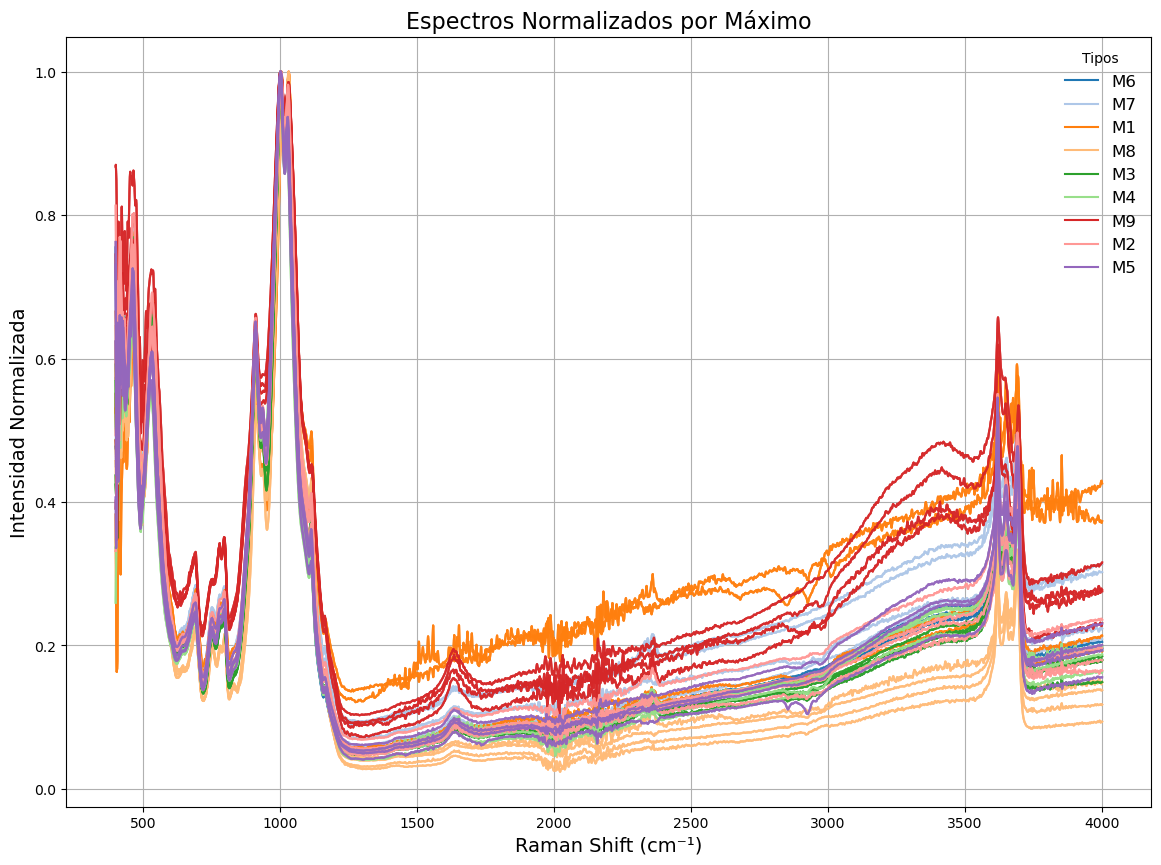

In [22]:
plot_normalized_spectra(df_normalized_max, "Espectros Normalizados por Máximo")

### Normalizados por Área
La normalización por área es un método común para escalar datos espectrales, como los espectros Raman, que ajusta cada valor del espectro dividiendo por el área total bajo la curva. Esto asegura que el área total de cada espectro sea igual a 1, permitiendo comparaciones más equitativas de las formas relativas de los espectros.

#### Cómo funciona la Normalización por Área

#### Calcular el área bajo la curva (AUC):
El área se calcula como la integral de la intensidad a lo largo de los valores del desplazamiento Raman (o eje X). 

En datos discretos, como los espectros Raman, se utiliza una suma aproximada o la **regla del trapecio** para estimar esta integral:

$$
A = \int f(x) \, dx \approx \sum_{i=1}^{n-1} \frac{f(x_{i+1}) + f(x_i)}{2} (x_{i+1} - x_i)
$$

En Python, esto se logra con la función `numpy.trapz`.

---

#### Dividir cada valor por el área total:
Una vez calculada el área (\( A \)), cada valor del espectro (\( x \)) se divide por \( A \):

$$
x_{\text{norm}} = \frac{x}{A}
$$

---

#### Resultado:
- Los valores del espectro escalados estarán en una **escala relativa**.
- El área bajo la curva del espectro normalizado será igual a **1**.


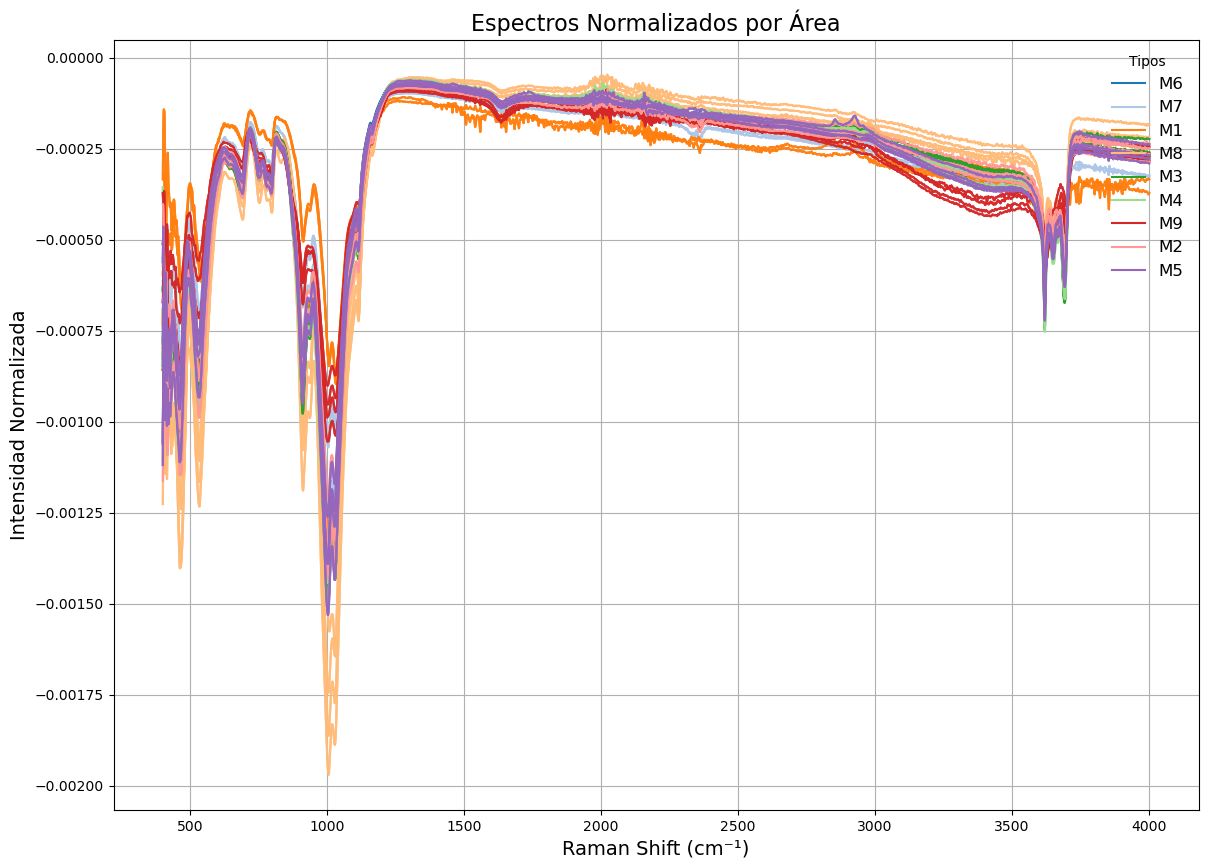

In [23]:
plot_normalized_spectra(df_normalized_area, "Espectros Normalizados por Área")


## Normalizacion Z-Score (Estandarización)
La normalización Z-Score, también conocida como estandarización, transforma los datos para que cada variable tenga una media de 0 y una desviación estándar de 1. Este método es especialmente útil para análisis estadísticos como el PCA, donde las escalas de las variables pueden afectar el resultado.

### Fórmula del Z-Score

Cada valor se transforma usando la fórmula:

$$
z = \frac{x - \mu}{\sigma}
$$

Donde:
- \( x \): Valor original.
- \( \mu \): Media de la variable.
- \( \sigma \): Desviación estándar de la variable.


<div class="alert alert-block alert-info">
<b>Interpretación de 
𝜎
σ en espectros Raman</b> 
    <br><font color=red>Desviación estándar pequeña:</font> La intensidad de los valores está más concentrada alrededor de la media, indicando picos más homogéneos.<br>
    <font color=red>Desviación estándar grande:</font> Los valores de intensidad están más dispersos, indicando variaciones significativas en el espectro.<br>
</div>




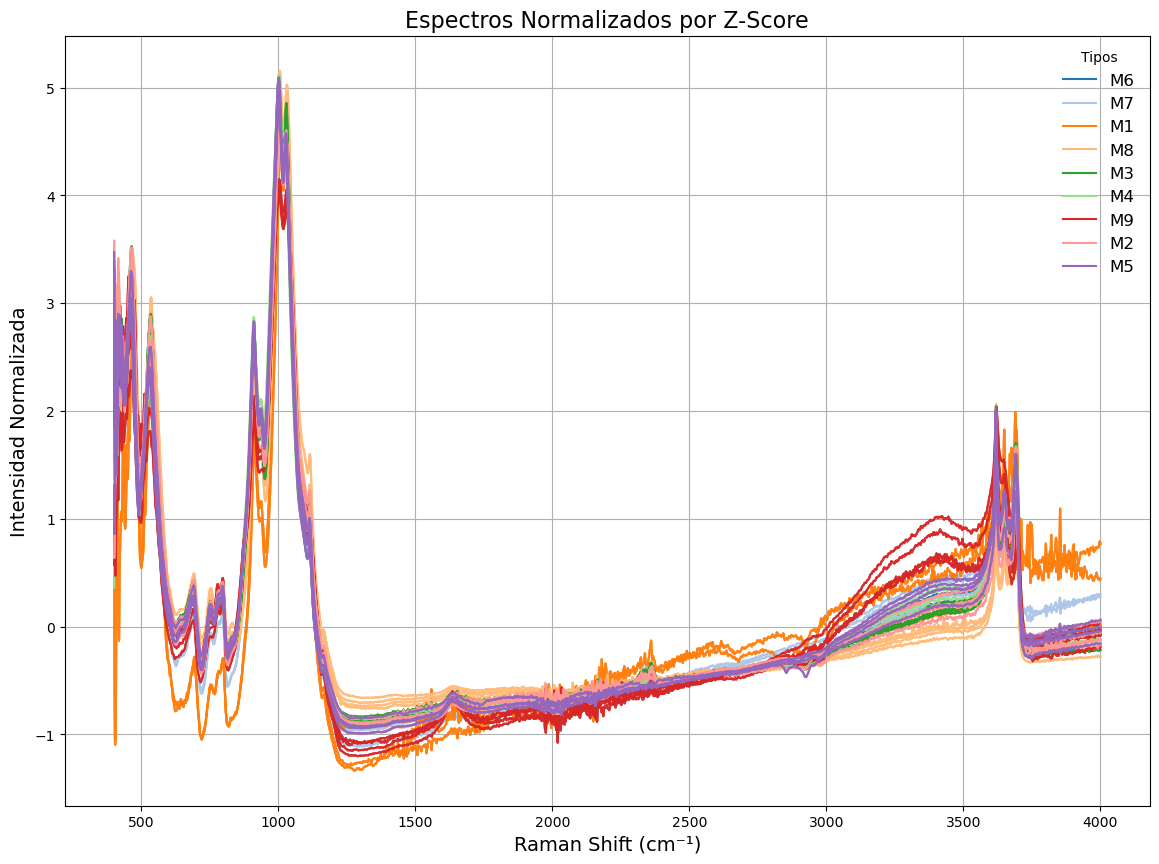

In [24]:
plot_normalized_spectra(df_normalized_zscore, "Espectros Normalizados por Z-Score")